<a href="https://colab.research.google.com/github/knitinsingh/GTD_predictive_model/blob/master/TS_25thfeb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


In [0]:
Tweet = pd.read_csv(io.StringIO(uploaded['Tweets.csv'].decode('utf-8')))


In [0]:
Tweet.head()

**Exploratory analysis**




To check the target variable i.e. airline_sentiment distribution

In [0]:
Tweet['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

A bar graph of the above distribution

In [0]:
Tweet_count=Tweet['airline_sentiment'].value_counts()

Text(0.5, 1.0, 'Bar graph of Sentiments')

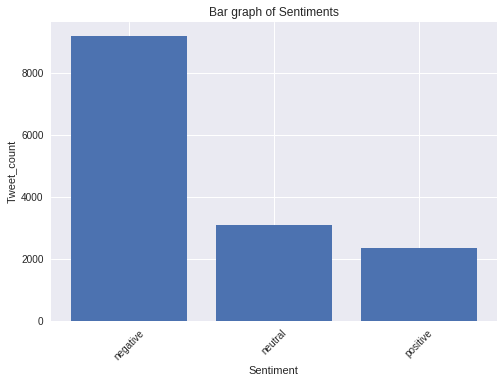

In [0]:
Index = [1,2,3]
plt.bar(Index,Tweet_count)
plt.xticks(Index,['negative','neutral','positive'],rotation=45)
plt.ylabel('Tweet_count')
plt.xlabel('Sentiment')
plt.title('Bar graph of Sentiments')

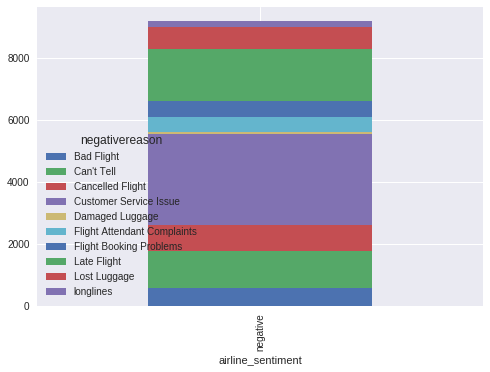

In [0]:
Tweet.groupby(['airline_sentiment', 'negativereason']).size().unstack().plot(kind='bar', stacked=True)


The above graph shows the stack bar chart of negative reasons across each sentiment.
As we see the negative reasons is rightly classified in the negative sentiment group.

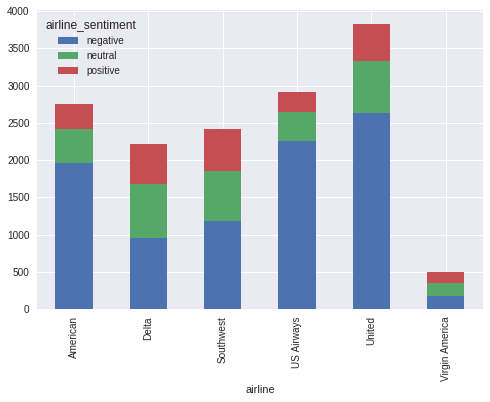

In [0]:
Tweet.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)


The above graph is a stack bar representation of all US airlines and their sentiments on twitter

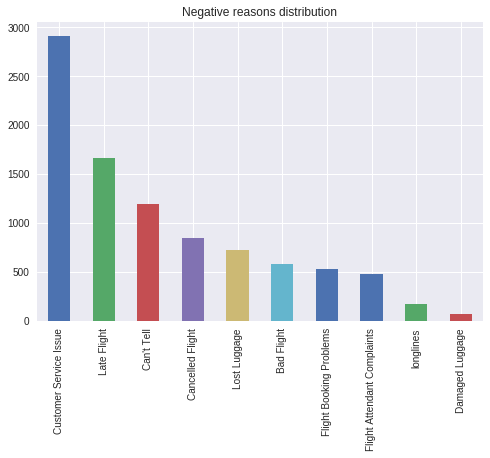

In [0]:
Tweet['negativereason'].value_counts().plot(kind='bar',title='Negative reasons distribution')


The above graph shows the distribution of all possible negative reasons a tweet is classified into.
Further we will be using couple of these reaons as our target variable and build a model using ULMFIT method.

In [0]:
from wordcloud import WordCloud,STOPWORDS

In [0]:
df=Tweet[Tweet['airline_sentiment']=='negative']
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [0]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

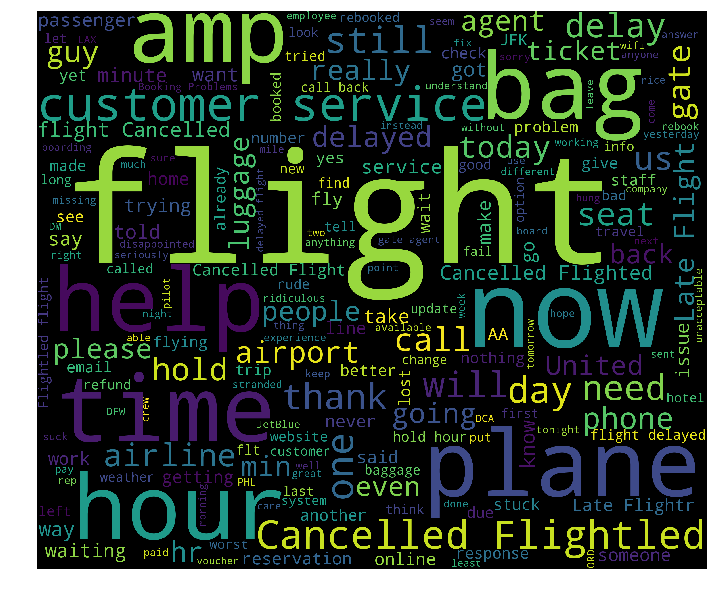

In [0]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#  Model building using some of the popular supervised machine learning algorithms

In [0]:
Tweet_ml = Tweet # Creating a new dataframe for ML based model

We will be using two classes in our target variable.
i.e. we will bin neutral and positive sentiments into one group.

In [0]:
Tweet_ml['sentiment']=Tweet_ml['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [0]:
Tweet_ml['sentiment'].value_counts()

0    9178
1    5462
Name: sentiment, dtype: int64

Some pre-processing techniques on text data before any supervised machine learning model

In [0]:
# Transforming tweets into lower cases
Tweet_ml['text'] = Tweet_ml['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))



In [0]:
# Removing puncuations

Tweet_ml['text']  = Tweet_ml['text'].str.replace('[^\w\s]','')


In [0]:
# Removing stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
Tweet_ml['text'] = Tweet_ml['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


In [0]:
# Average word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

Tweet_ml['avg_word'] = Tweet_ml['text'].apply(lambda x: avg_word(x))
Tweet_ml[['text','avg_word']].head()

,text,avg_word
0,virginamerica dhepburn said,8.333333
1,virginamerica plus youve added commercials exp...,7.571429
2,virginamerica didnt today must mean need take ...,5.555556
3,virginamerica really aggressive blast obnoxiou...,7.636364
4,virginamerica really big bad thing,6.000000


In [0]:
Tweet_ml['sentiment'].value_counts()

0    9178
1    5462
Name: sentiment, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn_ml, df_val_ml = train_test_split(Tweet_ml, stratify = Tweet_ml['sentiment'], test_size = 0.4, random_state = 12)

In [0]:
df_trn_ml.shape, df_val_ml.shape

((8784, 17), (5856, 17))

In [0]:
train_tweet=[]
for text in df_trn_ml['text']:
    train_tweet.append(text)
test_tweet=[]
for text in df_val_ml['text']:
    test_tweet.append(text)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(analyzer = "word")
df_trn_ml_tf= v.fit_transform(train_tweet)
df_val_ml_tf=v.transform(test_tweet)

In [0]:
df_trn_ml_tf

<8784x12051 sparse matrix of type '<class 'numpy.int64'>'
	with 87952 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [0]:
Classifiers = [
    #LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier()]

In [0]:
train_array=df_trn_ml_tf.toarray()
test_array= df_val_ml_tf.toarray()
    

In [0]:
Accuracy=[]
Model=[]

In [0]:
for classifier in Classifiers:
    try:
        fit = classifier.fit(df_trn_ml_tf,df_trn_ml['sentiment'])
        pred = fit.predict(df_val_ml_tf)
    except Exception:
        fit = classifier.fit(train_array,df_trn_ml['sentiment'])
        pred = fit.predict(test_array)
    accuracy = accuracy_score(pred,df_val_ml['sentiment'])
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy)) 
  

Accuracy of KNeighborsClassifieris 0.5293715846994536


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of SVCis 0.6268784153005464
Accuracy of DecisionTreeClassifieris 0.7400956284153005
Accuracy of RandomForestClassifieris 0.8080601092896175
Accuracy of AdaBoostClassifieris 0.7792008196721312


Model results of sentiment analysis using supervised machine learning techniques :- 

Accuracy of SVCis 0.6268784153005464

Accuracy of DecisionTreeClassifieris 0.7400956284153005

Accuracy of RandomForestClassifieris 0.8080601092896175

Accuracy of AdaBoostClassifieris 0.7792008196721312

As we can interpret from the above results :- 

Random forest classifier has the best accuracy of around 80.8 %


# ULMFiT Model


In [0]:
# Load Tweet data again.

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()


Saving Tweets.csv to Tweets (1).csv


In [0]:
Tweet = pd.read_csv(io.StringIO(uploaded['Tweets.csv'].decode('utf-8')))

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)
Tweet['text'] = Tweet['text'].apply(clean_ascii)

In [0]:
Tweet['label']=Tweet['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [0]:
df = Tweet[['label','text']]

In [0]:
df = df.reset_index(drop = True)


In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [0]:
df_trn.head()

,label,text
3874,1,@united Can I add miles from my January Air Ch...
8336,1,@JetBlue There's just so many choices for y'al...
10097,0,"@USAirways if you mean by posted, no USAir emp..."
11066,0,@USAirways @AmericanAir you know...hockey stic...
14154,0,@AmericanAir tomorrows flight Cancelled Flight...


In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [0]:
# Save the language and classifier model data for re-use
data_lm.save()

In [0]:
df_trn.shape

(8784, 2)

In [0]:
data_lm.show_batch()


idx,text
0,"# not accepting calls , no contact from usair re : rebook # xxunk xxbos @usairways @americanair you know ... xxunk xxunk are expensive . xxmaj your baggage handlers should n't just be throwing them on the cart . xxbos @americanair xxunk flight xxmaj cancelled xxmaj flighted . i understand . xxmaj three hour wait for a call back and now 60 minutes on hold . xxmaj not cool ."
1,xxbos @united unavailable leg that registered hours after being sold out . xxmaj only option to offer after 45min was + $ 400 / ticket or xxmaj travelocity ( xxunk ) xxbos @americanair xxmaj kudos to ticket agents for # xxunk for making passengers check bags that are too big to fit in overhead . xxbos @usairways 4 hrs and counting today alone ... like i do n't have other
2,"was lost in xxbos @united they had snacks available , just no fresh food ... not sure what happened , but i 'm sure we will grab a xxunk before our xxup sfo connection xxbos @jetblue what 's up w flt 4 ? xxmaj brothers fianc sitting on board for 30mins w tech issues . xxbos @southwestair - stuck on the runway , again . xxmaj delayed on xxmaj wednesday"
3,xxbos @usairways how do i find an email address regarding xxunk of dividend miles . xxmaj nothing on website xxbos @virginamerica xxup yes xxup fyi xxup my xxup bff xxbos @southwestair it 's never too xxmaj late xxmaj flight to do the right thing xxbos @united xxmaj how do i get through xxup @tsa to finally board xxup ua 1534 ? xxbos @americanair need help changing a flight . xxmaj
4,". xxmaj can buy first seat on same flight for $ 440 . xxmaj why ? xxmaj on hold for 45 + mins now xxbos @united what 's the hold up with flight xxunk from xxup slc to xxup den ? ? xxbos @southwestair xxmaj looks like ' xxmaj on xxmaj february 19 , 2015 , we will open our schedule for sale through xxmaj october 30 , 2015 '"


In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01


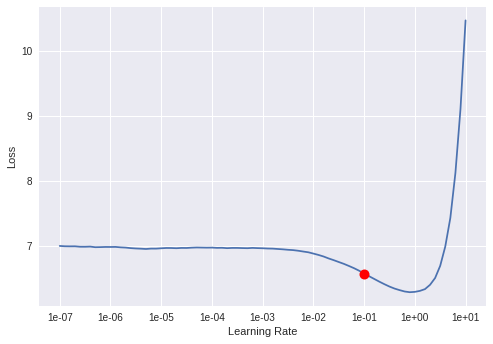

In [0]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy
1,6.647486,6.315709,0.162256


In [0]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,5.879969,5.268947,0.199505
2,5.424918,4.865821,0.223682
3,5.004866,4.293877,0.254987
4,4.546947,4.031585,0.265534
5,4.225422,3.868920,0.279011
6,3.975378,3.800303,0.283273
7,3.771493,3.751212,0.286656
8,3.578485,3.738455,0.287556
9,3.407330,3.748538,0.289146
10,3.228118,3.765902,0.288037


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

**Train classifier**

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
data_clas.save()


In [0]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM,drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-03


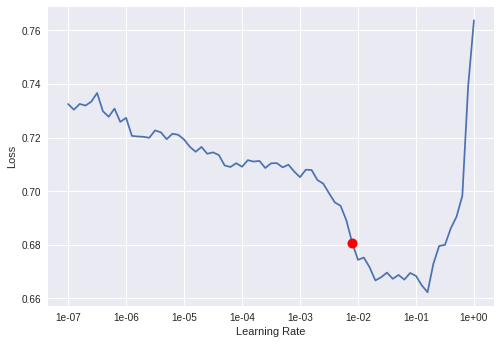

In [0]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy
1,0.540310,0.450148,0.786202


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.504096,0.402700,0.816940


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.491260,0.401755,0.818818


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.482623,0.396204,0.818477
2,0.464740,0.376856,0.829918
3,0.459572,0.390725,0.821038
4,0.437871,0.388855,0.821721


In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.299844,0.416927,0.839310
2,0.328582,0.364206,0.852459
3,0.339089,0.359239,0.851093
4,0.406891,0.473812,0.786714
5,0.324916,0.417542,0.840505
6,0.287804,0.378888,0.856728
7,0.256116,0.359736,0.858607
8,0.180162,0.498553,0.860314
9,0.179481,0.453895,0.861851
10,0.165221,0.467158,0.860143


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

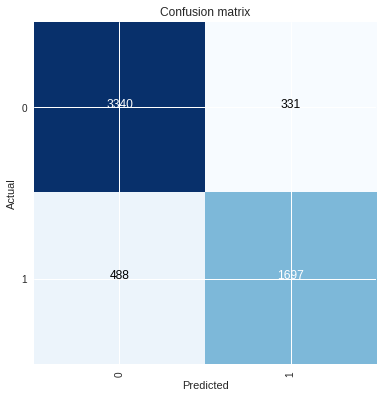

In [0]:
interp.plot_confusion_matrix()

The overall accuracy is around 86%

## Model building on specific negative reason issue 

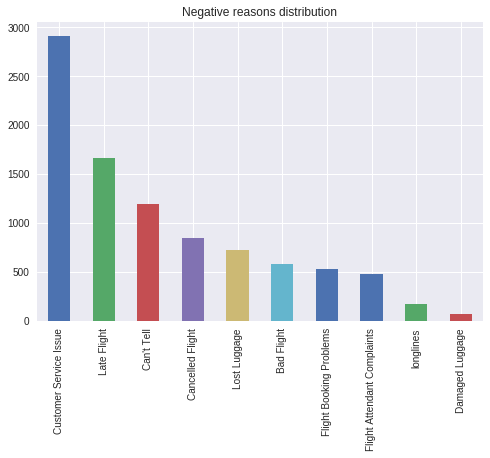

In [0]:
# Let us recall this distribution of negative reasons.
Tweet['negativereason'].value_counts().plot(kind='bar',title='Negative reasons distribution')


In the above graph we see the Customer service issue is the highest.

In [0]:
# Pick only airline sentiment as negative

In [0]:
Tweet_neg = Tweet.loc[Tweet['airline_sentiment'] == "negative"]

In [0]:
Tweet_neg.shape # (9178, 15)

(9178, 16)

In [0]:
Tweet_neg.negativereason.unique() # To check all unique reasons of negative sentiment

array(['Bad Flight', "Can't Tell", 'Late Flight', 'Customer Service Issue', 'Flight Booking Problems', 'Lost Luggage',
       'Flight Attendant Complaints', 'Cancelled Flight', 'Damaged Luggage', 'longlines'], dtype=object)

In [0]:
Tweet_neg['target'] = Tweet_neg['negativereason'].map(lambda x: 1 if (x == 'Customer Service Issue') else 0  )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


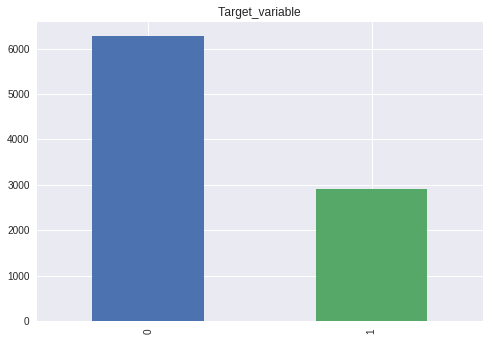

In [0]:
Tweet_neg['target'].value_counts().plot(kind='bar',title='Target_variable')

In [0]:
Tweet_neg.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,label,target
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0,0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0,0
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),0,0
15,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada),0,0
17,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),0,0


In [0]:
df_neg = Tweet_neg[['target','text']]

In [0]:
df_neg = df_neg.reset_index(drop = True)

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn_cs, df_val_cs = train_test_split(df_neg, stratify = df_neg['target'], test_size = 0.4, random_state = 12)

In [0]:
# Language model data
data_lm_cs = TextLMDataBunch.from_df(train_df = df_trn_cs, valid_df = df_val_cs, path = "")

In [0]:
data_lm_cs.save()

In [0]:
data_lm_cs.show_batch()

idx,text
0,"traveling around the world until the end of the year . 800 numbers do me no good . xxbos @united i think you guys had a half full flight at 4 so you held our overbooked 3 pm flight to fill the other one then xxmaj cancelled xxmaj flightled mine xxbos @americanair : @andrew_wasila xxmaj we 're sorry you were uncomfortable , xxmaj andrew . xxmaj what can we do"
1,"wheelchair , not a customer care form to fill out . xxbos @americanair xxmaj please stop changing my flights for xxmaj xxunk xxmaj break . xxmaj this is the 5th time ! xxbos @usairways xxmaj merging xxup aa and xxunk xxunk an error . xxmaj what are the _ exact _ steps to xxunk the phone xxunk ? xxmaj all i get is a computer . xxbos @americanair is there"
2,"flights ? xxbos @usairways i have to spend more than the cost of the flight just to get a free room and transportation to and from the airport xxbos @americanair but really , can you xxup dm me on here to verify if you 've booked a hotel for our extra night here ? xxmaj kinda xxunk to get a call xxbos @united look at the xxmaj twitter history -"
3,"# xxup faa xxmaj missing flt xxunk xxup clt to xxup xxunk , hope you can rebook me ! xxunk ? xxbos @americanair seems like queue times are very high , in q waiting for an agent 4 almost an hour . xxmaj flight got xxmaj cancelled xxmaj flightled . http : / / t.co / xxunk xxbos @americanair xxmaj what 's the status at xxup dfw ? xxmaj ticket"
4,"got rebooked on on us airways by you guys but the flight i got wo n't work . xxmaj any help would be appreciated . xxbos @virginamerica xxmaj hey , first time flyer next week - excited ! xxmaj but i 'm having a hard time getting my flights added to my xxmaj xxunk account . xxmaj help ? xxbos @americanair xxmaj you should really help @cowboycerrone out , you"


In [0]:
learn_cs = language_model_learner(data_lm_cs, arch=AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.26E-01


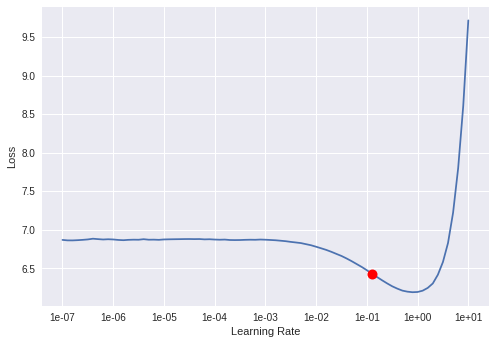

In [0]:
learn_cs.lr_find(start_lr=1e-8, end_lr=1e2)
learn_cs.recorder.plot()

In [0]:
learn_cs.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy
1,6.661819,6.366223,0.153876


In [0]:
learn_cs.unfreeze()
learn_cs.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,6.048243,5.415361,0.186840
2,5.602489,4.963364,0.213271
3,5.260522,4.617608,0.228998
4,4.872612,4.149641,0.256960
5,4.509817,3.989120,0.261790
6,4.221571,3.879189,0.273295
7,3.978467,3.819578,0.276654
8,3.824894,3.815937,0.275842
9,3.616670,3.797752,0.276349
10,3.431350,3.817815,0.274219


In [0]:
# Save the fine-tuned encoder
learn_cs.save_encoder('ft_enc_cs')

In [0]:
# Classifier model data
data_clas_cs = TextClasDataBunch.from_df(path = "", train_df = df_trn_cs, valid_df = df_val_cs, vocab=data_lm_cs.train_ds.vocab, bs=32)

In [0]:
data_clas_cs.save()


In [0]:
learn_cs = text_classifier_learner(data_clas_cs, arch=AWD_LSTM,drop_mult=0.5)
learn_cs.load_encoder('ft_enc_cs')
learn_cs.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.01E-03


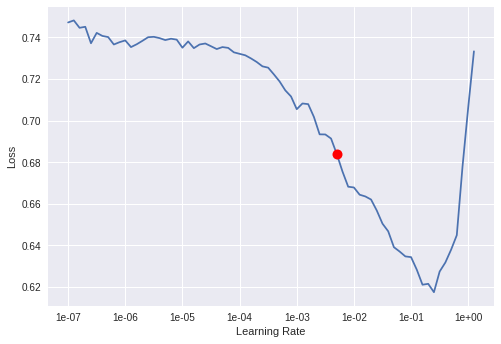

In [160]:
learn_cs.lr_find(start_lr=1e-8, end_lr=1e2)
learn_cs.recorder.plot()

In [0]:
learn_cs.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy
1,0.554647,0.497103,0.764978


In [0]:
learn_cs.freeze_to(-2)
learn_cs.fit_one_cycle(1, slice(1e-4,1e-1), moms=(0.8,0.7))

In [149]:
learn_cs.freeze_to(-3)
learn_cs.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.502660,0.433570,0.804739


In [161]:
learn_cs.unfreeze()
learn_cs.fit_one_cycle(4, slice(1e-4,1e-1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.496708,0.615534,0.683551
2,0.514065,0.521622,0.812636
3,0.439498,0.410816,0.827887
4,0.413597,0.404948,0.825708
